# Developing Model

## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

## Load Dataset

In [2]:
csv = pd.read_csv('/data/data_challenge.csv')
csv.head()

,idHistory,vehicle_type,vehicle_name,fuel_type,machine_capacity,daily_emission,distance,location,location_address,time_used,time_travel,user_id,avg_daily_emission,avg_distance_user,motor_counts,mobil_counts,challenge_id,chal_name
0,2be4f812-81b0-4df2-a831-614e56a15e95,mobil,Suzuki Ertiga,Pertalite,250,805512,1479,Warkop Pak Min,"Turus, Ternyang, Sumberpucung, Malang Regency,...",2023-03-21 00:00:00,120,7eaf6a97-b960-40ef-971f-ad77580d7bfa,2139303.4,23887.9,6,4,CHALLENGE027,Eco Friend Meetup
1,0acfb7fb-ada5-4a7a-9f78-72645935c820,sepeda motor,Honda Beat,Pertamax Turbo,2000,806546,36364,sabila snack,"Jalan Randupitu-Gunung Gangsir, Pagar Gunung, ...",2023-08-29 00:00:00,159,955e4fb4-95da-4e87-adee-2a7fff479979,2186638.1,19709.3,8,2,CHALLENGE015,Eco Grocer
2,f7feef39-033e-4a8b-a186-934365248ccc,mobil,Suzuki Ertiga,Diesel,150,4259071,12174,Universitas Yudharta Pasuruan,"Jl. Yudharta, Kembangkuning, Sengonagun, Pasur...",2023-06-05 00:00:00,153,913faf2b-3f75-4281-b76d-a62e69c2673c,3264225.0,24096.8,6,4,CHALLENGE027,Eco Friend Meetup
3,d10cec6b-e90d-42ca-aef6-dfd325022df8,sepeda motor,Kawasaki Ninja,Shell Super,1800,3059045,6517,Pakuwon Mall,"Jalan Mayjend. Jonosewojo, Babatan, Surabaya, ...",2023-06-29 00:00:00,176,955e4fb4-95da-4e87-adee-2a7fff479979,2186638.1,19709.3,8,2,CHALLENGE003,Green Mile
4,d82fbea0-e18e-4738-8725-c2e765496486,mobil,Toyota Avanza,Shell Super,200,3480107,20097,Jalan Semampir Tengah IIA No.17,"Medokan Semampir, Surabaya, East Java, Indonesia",2023-02-20 00:00:00,110,11c40027-0c39-42b0-9f2c-7f689a4fe902,2604622.2,28674.7,4,6,CHALLENGE004,Zero Emissions Day


## Keep Relevant Features

Keep the relevant features for the model and convert time_used column into datetime datatype.

In [3]:
new_data = csv[['user_id', 'challenge_id', 'vehicle_type', 'time_used', 'daily_emission', 'avg_daily_emission', 'avg_distance_user']]
new_data['time_used'] = pd.to_datetime(new_data['time_used'])

<ipython-input-3-a82ba62cd09d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['time_used'] = pd.to_datetime(new_data['time_used'])


Sort the data by user_id and time_used in ascending order.

In [4]:
new_data = new_data.sort_values(by=['user_id', 'time_used'])
new_data.head()

,user_id,challenge_id,vehicle_type,time_used,daily_emission,avg_daily_emission,avg_distance_user
316,015fc899-ae7a-4301-9e54-29634bcef4c3,CHALLENGE010,sepeda motor,2023-02-16,1155980,2292038.9,26690.2
282,015fc899-ae7a-4301-9e54-29634bcef4c3,CHALLENGE011,sepeda motor,2023-02-26,674931,2292038.9,26690.2
202,015fc899-ae7a-4301-9e54-29634bcef4c3,CHALLENGE003,sepeda motor,2023-04-27,384110,2292038.9,26690.2
324,015fc899-ae7a-4301-9e54-29634bcef4c3,CHALLENGE029,sepeda motor,2023-04-30,4339994,2292038.9,26690.2
289,015fc899-ae7a-4301-9e54-29634bcef4c3,CHALLENGE005,mobil,2023-06-12,380011,2292038.9,26690.2


## Encoded Categorical Columns

In [5]:
user_encoder = LabelEncoder()
new_data['user_id_encoded'] = user_encoder.fit_transform(new_data['user_id'])

challenge_encoder = LabelEncoder()
new_data['challenge_id_encoded'] = challenge_encoder.fit_transform(new_data['challenge_id'])

vehicle_encoder = LabelEncoder()
new_data['vehicle_type_encoded'] = vehicle_encoder.fit_transform(new_data['vehicle_type'])

## Create the interaction matrix

This matrix represents the user-challenge interactions, with users as rows, challenges as columns, and the frequency of participation as the values.

In [6]:
data_processed = new_data[['user_id_encoded', 'challenge_id_encoded', 'vehicle_type_encoded', 'time_used', 'daily_emission', 'avg_daily_emission', 'avg_distance_user']]
interaction_matrix = data_processed.pivot_table(index='user_id_encoded', columns='challenge_id_encoded', aggfunc='size', fill_value=0)

In [7]:
interaction_matrix.head()

challenge_id_encoded,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
user_id_encoded,,,,,,,,,,,,,,,,,,,,,
0,0,1,1,0,1,0,0,0,1,1,...,0,0,1,0,0,1,1,1,0,1
1,0,1,0,0,0,1,0,0,1,0,...,0,0,1,0,1,1,1,0,1,1
2,1,0,0,0,1,1,0,1,0,1,...,1,0,0,0,1,1,0,1,0,1
3,0,0,0,1,1,1,0,1,0,1,...,1,1,1,0,0,1,0,0,0,1
4,0,1,0,1,0,1,0,1,0,1,...,0,0,0,0,1,1,0,0,1,1


## Dimensionality Reduction on Interaction Matrix using SVD

### Choosing n_components

Look for the point where the cumulative variance reaches a high value (for ex: 90% or 95%). Beyond this point, adding more components contributes very little to explaining the data.

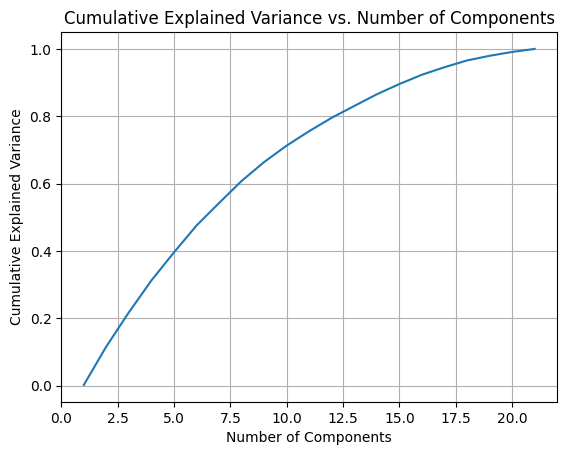

In [8]:
svd = TruncatedSVD(n_components=21)
svd.fit(interaction_matrix)

cumulative_variance = np.cumsum(svd.explained_variance_ratio_)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

### SVD to extract Latent Factor

In [9]:
svd = TruncatedSVD(n_components=15)
user_latent_factors = svd.fit_transform(interaction_matrix)
challenge_latent_factors = svd.components_.T

## Split dataset

In [10]:
user_ids = new_data['user_id_encoded'].unique()
train_user_ids, val_user_ids = train_test_split(user_ids, test_size=0.2, random_state=42)
train_data = new_data[new_data['user_id_encoded'].isin(train_user_ids)]
val_data = new_data[new_data['user_id_encoded'].isin(val_user_ids)]

## Model using RNN LSTM and SVD for Collaborative Filtering

In [35]:
latent_dim = 15

user_input = Input(shape=(latent_dim,), name='user_input')
challenge_input = Input(shape=(latent_dim,), name='challenge_input')
vehicle_input = Input(shape=(1,), name='vehicle_input')

merged = Concatenate()([user_input, challenge_input, vehicle_input])

merged_reshaped = Reshape((1, latent_dim * 2 + 1))(merged)

lstm_output = LSTM(64, return_sequences=False)(merged_reshaped)

dense_output = Dense(64, activation='relu')(lstm_output)
dropout_output = Dropout(0.2)(dense_output)

output = Dense(interaction_matrix.shape[1], activation='softmax')(dropout_output)

model = Model(inputs=[user_input, challenge_input, vehicle_input], outputs=output)

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 15)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ challenge_input           │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vehicle_input             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 31)             │              0 │ user_input[0][0],      │
│ (Concatenate)             │                        │                │ challenge_input[0][0], │
│                           │                        │                │ vehicle_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 1, 31)          │              0 │ concatenate_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ (None, 64)             │         24,576 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 64)             │          4,160 │ lstm_5[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_5 (Dropout)       │ (None, 64)             │              0 │ dense_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 21)             │          1,365 │ dropout_5[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,101 (117.58 KB)

 Trainable params: 30,101 (117.58 KB)

 Non-trainable params: 0 (0.00 B)

## Training Model

In [36]:
history = model.fit(
    [user_latent_factors[train_data['user_id_encoded'].values],
     challenge_latent_factors[train_data['challenge_id_encoded'].values],
     train_data['vehicle_type_encoded'].values],
    train_data['challenge_id_encoded'].values,
    epochs=16,
    batch_size=32,
    validation_data=(
        [user_latent_factors[val_data['user_id_encoded'].values],
         challenge_latent_factors[val_data['challenge_id_encoded'].values],
         val_data['vehicle_type_encoded'].values],
        val_data['challenge_id_encoded'].values
    ),
)


Epoch 1/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.0502 - loss: 3.0475 - val_accuracy: 0.0600 - val_loss: 3.0307
Epoch 2/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0804 - loss: 3.0274 - val_accuracy: 0.1100 - val_loss: 3.0135
Epoch 3/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1026 - loss: 3.0026 - val_accuracy: 0.1300 - val_loss: 2.9927
Epoch 4/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0940 - loss: 2.9771 - val_accuracy: 0.1400 - val_loss: 2.9644
Epoch 5/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1553 - loss: 2.9274 - val_accuracy: 0.1700 - val_loss: 2.9257
Epoch 6/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1794 - loss: 2.8765 - val_accuracy: 0.2000 - val_loss: 2.8736
Epoch 7/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2562 - loss: 2.8174 - val_accuracy: 0.3200 - val_loss: 2.8016
Epoch 8/16
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3531 - loss: 2.7371 - val_accuracy: 0.4500 - val_loss

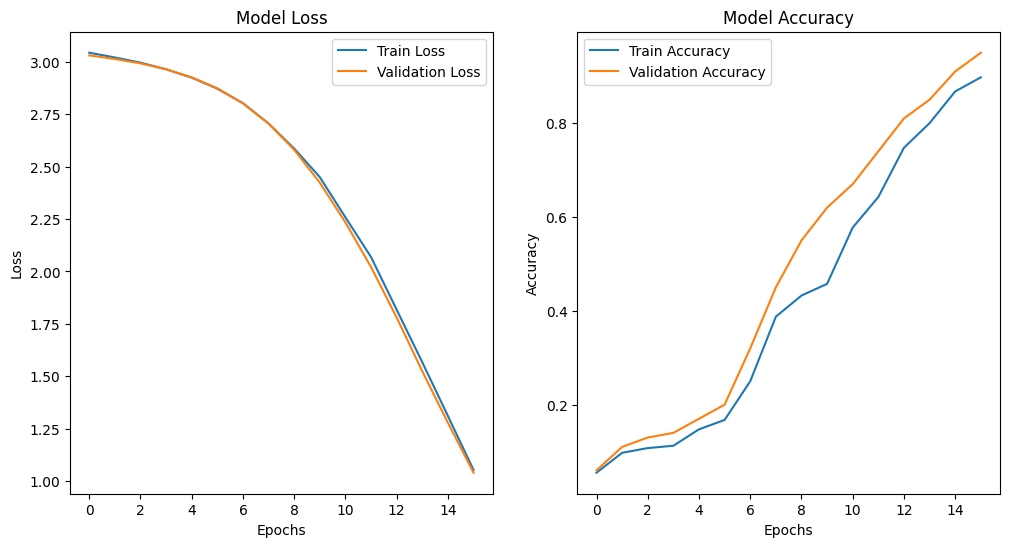

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Conclusion

Combining SVD and LSTM in a recommender system allows for effective modeling of both latent factors and sequential dependencies. SVD extracts hidden patterns from the user-item interaction matrix, improving recommendations by reducing dimensionality and preventing overfitting. LSTM captures time-dependent user behavior, learning evolving patterns and preferences over time. Together, they provide a personalized, context-aware recommendation system that adapts to both static preferences and dynamic changes in user activity.